In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import keras.backend as K
import ast

n_points=1000
noise_level=0.05
masse_min, masse_max = 0, 1000


In [ ]:
couches = [300, 300, 300, 300]                    #val_loss=2.56, val_mse= 1.6e-4
#couches = [500, 500, 500]                        #val_loss=???, val_mse= ???
#couches = [500, 100, 100, 500]                   #val_loss=???, val_mse= ???
#couches = [200, 200, 500, 500]                   #val_loss=???, val_mse= ???
#essaye en plein !

In [ ]:
# Données réelles
# max n : 29098

def sample_dataset(n):

  MSdata = pd.read_csv('MSdata.csv', encoding='mac_roman')
  sample=MSdata.sample(n=n).reset_index(drop=True)

  X, Y = np.empty((n,n_points)), np.empty((n,n_points))

  for i in range(n):
    Signal0=np.zeros((n_points))
    peaks = ast.literal_eval(str(sample['peak'][i]).replace("'",""))
    intensites = ast.literal_eval(str(sample['intensitÈ'][i]).replace("'",""))
    for k in range(len(peaks)) :
      if peaks[k]<masse_max:
        Signal0[n_points*int(peaks[k])//(masse_max-masse_min)]=intensites[k]/max(intensites)
    
    Y[i]=Signal0
        
    Signal1=Signal0+np.random.normal(0,noise_level,size=(n_points))
    X[i]=Signal1
        
  return(X, Y)


#nombre de spectres pour entraîner
n=10000
X_train, Y_train = sample_dataset(n)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
input_shape=X_train.shape[1:]


#%%
model=models.Sequential()

for i in range(len(couches)):
  model.add(layers.Dense(couches[i], activation='relu', input_shape=input_shape))
  model.add(layers.Dropout(0.2))

model.add(layers.Dense(1))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())

def customloss(y_true, y_pred) :
  penalty_coef=1
  mse = K.sum(K.square(y_pred-y_true))
  penalty = K.mean(K.square(y_pred))
  return mse+penalty_coef*penalty

model.compile(optimizer='rmsprop',
              loss=customloss,
              metrics=['mse'])

model.fit(X_train, Y_train, batch_size=16, epochs=3, validation_split=0.2)



Epoch 1/3
500/500 [==============================] - 9s 11ms/step - loss: 10.3747 - mse: 6.4834e-04 - val_loss: 2.4509 - val_mse: 1.5312e-04
Epoch 2/3
500/500 [==============================] - 5s 11ms/step - loss: 7.2026 - mse: 4.5008e-04 - val_loss: 3.8408 - val_mse: 2.4000e-04
Epoch 3/3
500/500 [==============================] - 5s 11ms/step - loss: 6.8778 - mse: 4.2979e-04 - val_loss: 2.6660 - val_mse: 1.6656e-04


In [ ]:
X_test, Y_test = sample_dataset(10000)

loss, mse = model.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), Y_test, batch_size=16)

print("mse sur l'ensemble de test : ", mse)

625/625 [==============================] - 2s 3ms/step - loss: 2.6357 - mse: 1.6467e-04
mse sur l'ensemble de test :  0.0001646679302211851


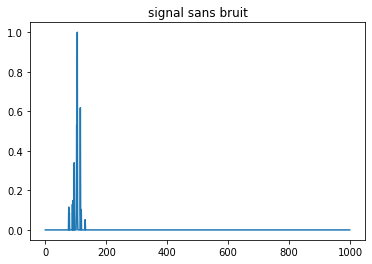

In [ ]:
#%%

#%%
plt.plot(Y_train[0].flatten())
plt.title("signal sans bruit")
plt.show()

plt.plot(X_train[0].flatten())
plt.title("signal avec bruit")
plt.show()

pred=model.predict(X_train[0:1]).flatten()
pred=pred*max((X_train[0:1]).flatten())/abs(max(pred))

plt.plot(pred)
plt.title('signal débruité')
plt.show()

plt.plot(np.where(pred<0.03, 0, pred))
plt.title('signal débruité seuillé')
plt.show()


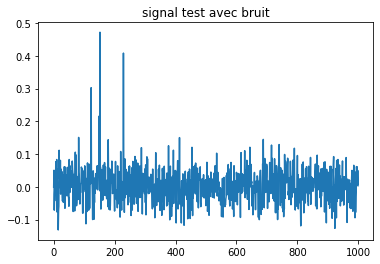

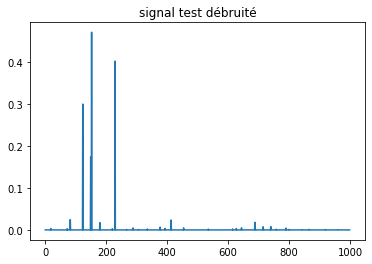

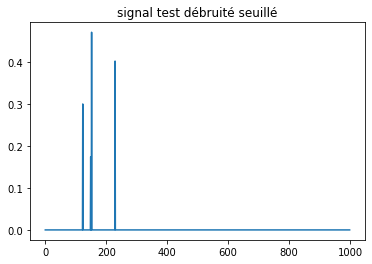

In [ ]:
X_test, Y_test = sample_dataset(1)

plt.plot(Y_test.flatten())
plt.title("signal test sans bruit")
plt.show()

plt.plot(X_test.flatten())
plt.title("signal test avec bruit")
plt.show()

pred=model.predict(X_test.reshape(1,1000,1)).flatten()
pred=pred*max(X_test.flatten())/abs(max(pred))

plt.plot(pred)
plt.title('signal test débruité')
plt.show()

plt.plot(np.where(pred<0.03, 0, pred))
plt.title('signal test débruité seuillé')
plt.show()

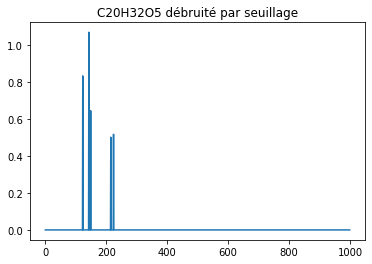

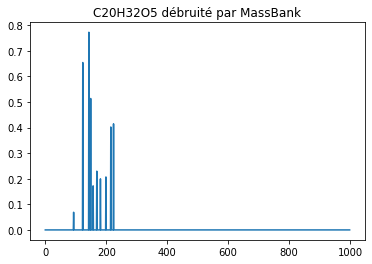

In [ ]:
index = 345

MSdata = pd.read_csv('MSdata.csv', encoding='mac_roman')
X, Y = np.zeros((n_points)), np.zeros((n_points))

name = MSdata['Formule chimique'][index]
peaks = ast.literal_eval(str(MSdata['peak'][index]).replace("'",""))
intensites = ast.literal_eval(str(MSdata['intensitÈ'][i]).replace("'",""))
for k in range(len(peaks)) :
  if peaks[k]<masse_max:
    Y[n_points*int(peaks[k])//(masse_max-masse_min)]=intensites[k]/max(intensites)
        
X=Y+np.random.normal(0,noise_level,size=(n_points))

plt.plot(Y)
plt.title(name+" sans bruit")
plt.savefig(name+"_sans_bruit.jpg")
plt.show()


plt.plot(X)
plt.title(name+" bruité")
plt.savefig(name+"bruit.jpg")
plt.show()

Y_seuil = np.where(X<0.3, 0, X)
plt.plot(Y_seuil)
plt.title(name +" débruité par seuillage")
plt.savefig(name+"_seuillage.jpg")
plt.show()

Y_pred = model.predict(X)
Y_pred = np.where(Y_pred<0.05, 0, Y_pred)
plt.plot(Y_pred)
plt.title(name+" débruité par MassBank")
plt.savefig(name+"_massbank.jpg")
plt.show()